# Phase 5 Capstone Project
## Neural Style Transfer
### Authored by Trinity Gahagen
---
---

# Overview

Neural Style Transfer is a fairly recent development in the field of deep learning, with the earliest concept of style transfer using neural networks being published in 2016 by Leon Gatys, Alexander Ecker, and Matthias Bethge in their research paper *Image Style Transfer Using Convolutional Neural Networks*. In essence, it is a method in which we use a pre-trained convolutional neural network to extract features from two images: one "content" image and one "style" image. Then, we combine the two in such a way that the "style" of the style image is blended together with the "content" of the content image to create a new, third generative image.

In this project, I attempt to recreate/explore this method using [Tensorflow's tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer), using the original paper as a backbone for understanding the underlying components.

Before jumping straight into modeling, we'll perform a really basic exploration of the data we're working with and demonstrate a really simple implementation of TensorflowHub's pretrained arbitrary style transfer method.

# Table of Contents

# Brief EDA
---

In [104]:
# Basic imports
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import re

# Image tool imports
from PIL import Image, ImageOps
import cv2

# Deep learning imports
import tensorflow as tf
import tensorflow_hub as hub
import h5py

In [105]:
# List content paths and style paths
CONTENT_DIRECTORY = "images/content/"
STYLES_DIRECTORY = "images/styles/"

In [106]:
# Look at the list of content images
content_names = os.listdir(CONTENT_DIRECTORY)
content_names

['beach.jpg',
 'bird_at_beach.jpg',
 'cat.jpg',
 'desert_1.jpg',
 'desert_2.jpg',
 'desert_3.jpg',
 'flower.jpg',
 'octopus.jpg',
 'person.jpg',
 'seashell.jpg',
 'sunset.jpg']

In [107]:
# Look at the list of style images
style_names = os.listdir(STYLES_DIRECTORY)
style_names

["at_the_water's_edge_.jpg",
 'chateau_noir_.jpg',
 'dance_hall_bellevue__obverse__.a.jpg',
 'el_rio_de_luz_(the_river_of_light)_.jpg',
 'flecks_of_foam_.jpg',
 'genesis_ii_.jpg',
 'glass_and_checkerboard_.jpg',
 'haystacks_in_brittany_.jpg',
 'keelmen_heaving_in_coals_by_moonlight_.jpg',
 'landscape_.jpg',
 'lumber_schooners_at_evening_on_penobscot_bay_.jpg',
 'melon_and_lemon_.jpg',
 'moonlight_.jpg',
 'new_york_.jpg',
 'place_du_carrousel,_paris_.jpg',
 'political_drama_.jpg',
 'red_path,_st._prex_.jpg',
 'salem_cove_.jpg',
 'seascape_(gravelines)_.jpg',
 'swiss_landscape_.jpg',
 'the_bend_in_the_road_.jpg',
 'the_evening_of_the_deluge_.jpg',
 'the_harvest_.jpg',
 'the_houses_of_parliament,_sunset_.jpg',
 'the_island_of_raguenez,_brittany_.jpg',
 'the_olive_orchard_.jpg',
 'the_peppermint_bottle_.jpg',
 'the_visit_-_couple_and_newcomer_.jpg',
 'the_watering_can_(emblems__the_garden)_.jpg',
 'two_poplars_in_the_alpilles_near_saint_-_remy_.jpg',
 'venice_.jpg',
 'weasels_at_play_.jpg'

In [108]:
# Create a list of paths for all images in each directory
style_paths = [os.path.join(STYLES_DIRECTORY, name) for name in style_names]
content_paths = [os.path.join(CONTENT_DIRECTORY, name) for name in content_names]

### How many images are in each folder?

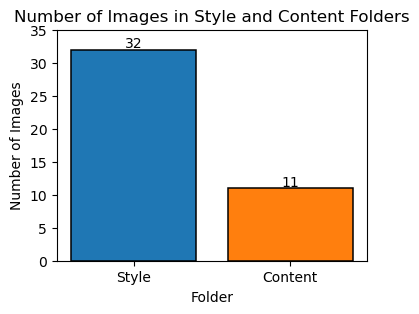

In [109]:
# Create a plot showing the number of files in each directory
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x=[0, 1], height=[len(style_names), len(content_names)], lw=1.1, edgecolor='black', color=['tab:blue', 'tab:orange'])
ax.set_ylim(0, 35)
ax.annotate(len(style_names),
            xy=(0, len(style_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.annotate(len(content_names),
            xy=(1, len(content_names) + 0.025 * 35),
            va='center',
            ha='center')
ax.set_xticks([0, 1], labels=['Style', 'Content'])
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Style and Content Folders')
ax.set_xlabel('Folder');

There are 32 images in my styles folder and 11 images in my content folder.

In [110]:
# List of example images to plot
example_styles = [Image.open(path) for path in style_paths[:9]]

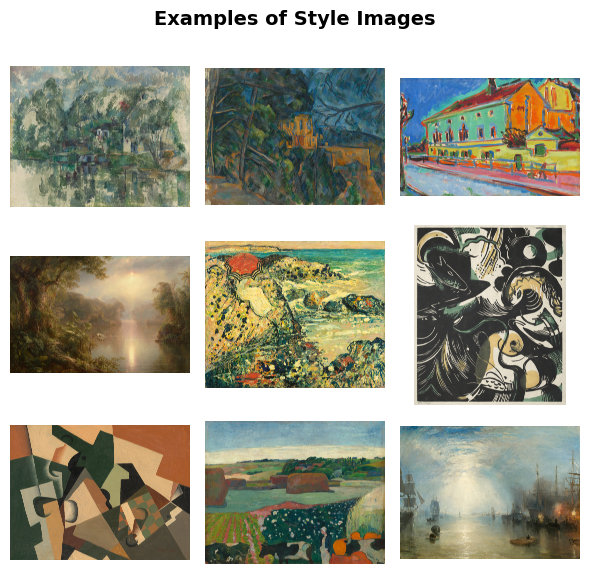

In [111]:
# Plot example images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle('Examples of Style Images', weight='bold', size=14)
for i in range(9):
    ax = axes[i // 3, i % 3]
    ax.set_axis_off()
    ax.imshow(example_styles[i])
plt.tight_layout();

All of the style images worked with in this notebook are public domain images downloaded from the [National Gallery of Art's website](https://www.nga.gov/open-access-images.html).

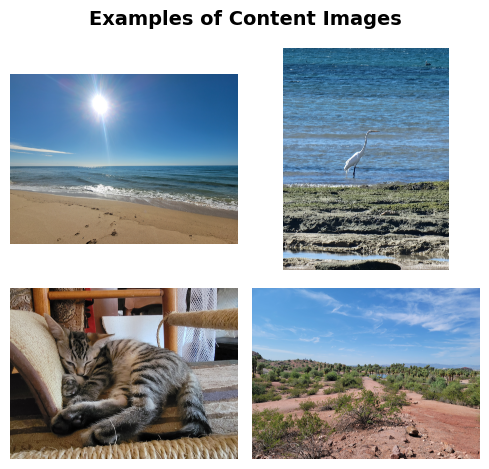

In [112]:
# Do the same for content images
example_content = [ImageOps.exif_transpose(Image.open(path)) for path in content_paths[:4]]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
fig.suptitle('Examples of Content Images', weight='bold', size=14)
for i in range(4):
    ax = axes[i // 2, i % 2]
    ax.set_axis_off()
    ax.imshow(example_content[i])
plt.tight_layout();

All of the content images worked with in this notebook are photographs I took with my own smartphone camera.

# Demonstrating Neural Style Transfer Using TensorflowHub

The following code snippet was copied and slightly adapted from [*this*](https://dev.to/chefgideon/unlocking-artistry-a-guide-to-neural-style-transfer-34g6) website, and will be used to demonstrate the general direction of this project.

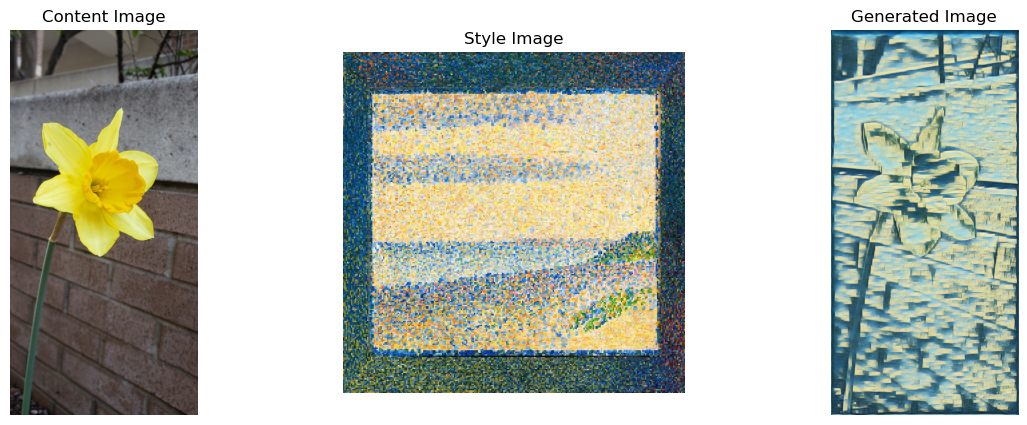

In [113]:
def preprocess_and_view_image(content_image_path, style_image_path):
    """
    Creates a plot of a content image, a style image,
    and a generated image that is a combination of the two.
    Parameters:
    ---
    content_image_path: str
        The path of the content image
    
    style_image_path: str
        The path of the style image
    """
    # Open the images and convert them to numpy arrays
    content_image = np.array(ImageOps.exif_transpose(Image.open(content_image_path)))
    style_image = plt.imread(style_image_path)
    content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
    style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.

    # Convert the images to tensors and upload the TensorflowHub module for image stylization
    style_image = tf.image.resize(style_image, [256, 256])
    hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

    # Retrieve generated image and convert to an numpy array for plotting purposes
    outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
    stylized_image = outputs[0]
    stylized_image_array = stylized_image.numpy()
    stylized_image_array = np.clip(stylized_image_array, 0, 1)

    # Plot the original content, the style image, and the generated image
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(content_image[0])
    plt.title('Content Image')
    plt.axis(False)
    plt.subplot(132)
    plt.imshow(style_image[0])
    plt.title('Style Image')
    plt.axis(False)
    plt.subplot(133)
    plt.imshow(stylized_image_array[0])
    plt.title('Generated Image')
    plt.axis(False)
    plt.show()

# Input a content and style image into the function
random_content = 'images/content/flower.jpg'
random_style = 'images/styles/seascape_(gravelines)_.jpg'
preprocess_and_view_image(random_content, random_style)

Here we can see that the content image and the style image are sort of "smooshed" together to form a third, combination image that takes the style of Georges Seurat's *Seascape (Gravelines)* and applies it to the real-life photo of a flower.

While this method technically does the job, it doesn't really capture the style of the style image very well. It seemingly just creates a style-inspired filter and overlays it onto the original content image. It doesn't capture any of the dotted textures that are prevalent in the original painting, and instead blends the dots together.

In the section Architecture Building: Part 1, I attempt to understand and recreate the original method of style using Tensorflow's tutorial as a guide, but the results do not work as intended. In the section Architecture Building: Part 2, I follow the tutorial much more closely and end up with a model that does work as intended. Further functionalization and exploration is done in Architecture Building: Part 3.

# Exploring VGG-19

In the original paper, the authors used layers from the pretrained VGG-19 neural network to extract higher-level features from the two different input images. Why is this? Let's explore a little bit to find out.

In [114]:
# Load the pre-trained VGG-19 model, without the fully connected dense layers
vgg = tf.keras.applications.VGG19(include_top=False)

In [115]:
# Look at the architecture of the model
vgg.layers

[<InputLayer name=input_layer_4, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <Conv2D name=block3_conv4, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <Conv2D name=block4_conv4, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <Conv2D name=block5_conv4, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [210]:
for layer in vgg.layers:
    print(layer.name)

input_layer_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [116]:
Model = tf.keras.models.Model

In [178]:
example_layers = ['block1_conv1',
                  'block1_conv2',
                  'block2_conv1',
                  'block3_conv1',
                  'block5_conv1']

intermediate_outputs = [vgg.get_layer(layer).output for layer in example_layers]

visualization_model = Model(inputs=vgg.input, outputs=intermediate_outputs)

(3000, 4000, 3)


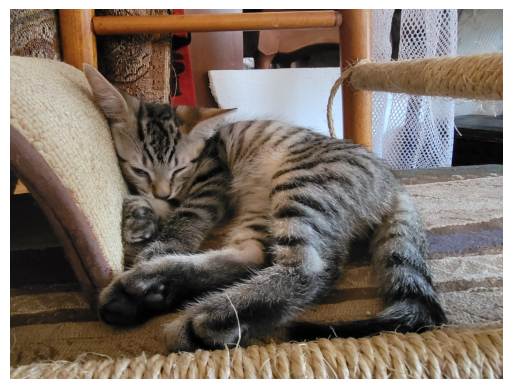

In [211]:
image_path = 'images/content/cat.jpg'

image = cv2.imread(image_path)
print(image.shape)
plt.imshow(image[:,:,::-1])
plt.axis('off');

In [212]:
# Rescale to an image with a max dimension of 500 pixels
scale_factor = 500 / max(image.shape)
scaled_height = int(image.shape[0] * scale_factor)
scaled_width = int(image.shape[1] * scale_factor)
image = cv2.resize(image, (scaled_width, scaled_height))
print(image.shape)

(375, 500, 3)


In [213]:
image = image / 255.0
image = tf.convert_to_tensor(image)
image = tf.expand_dims(image, axis=0)

In [214]:
image.shape

TensorShape([1, 375, 500, 3])

In [215]:
outputs = visualization_model(image)

In [216]:
def visualize_features(tensor, layer, n_features=9):
    n_subplots = int(np.sqrt(n_features))
    fig, axes = plt.subplots(n_subplots, n_subplots)
    array = tf.squeeze(tensor).numpy()
    first_n_feats = array[:, :, :n_features]
    for i in range(n_features):
        ax = axes[i // n_subplots, i % n_subplots]
        plot = first_n_feats[:, :, i] * 255
        fig.suptitle(f'First {n_features} Feature Maps of Layer ' + layer)
        ax.imshow(plot)
        ax.set_axis_off()
        plt.tight_layout()

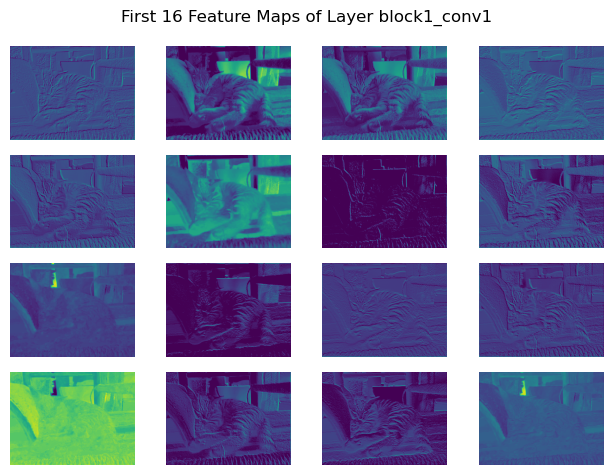

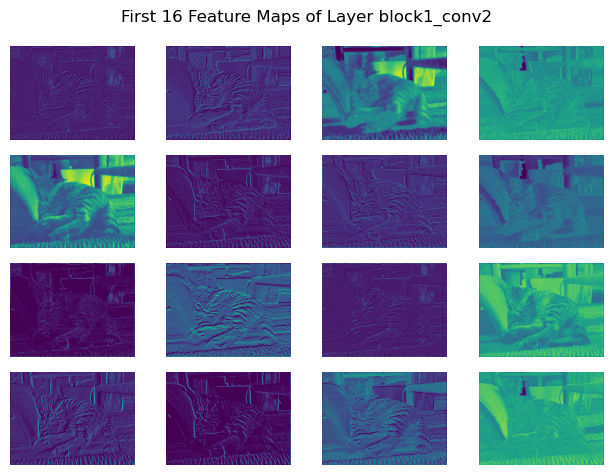

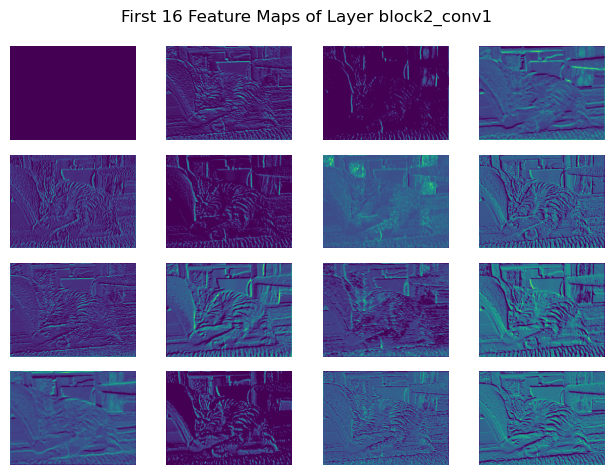

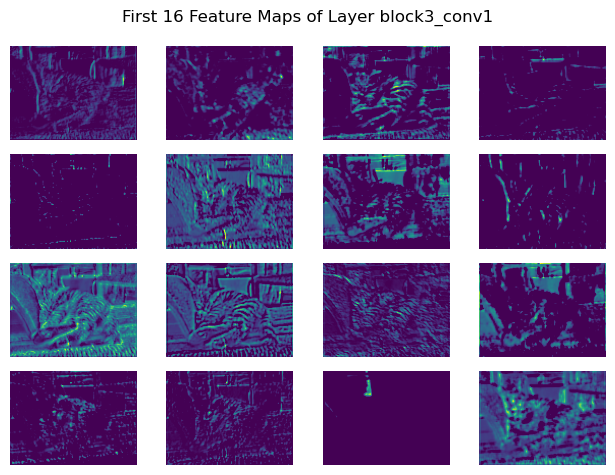

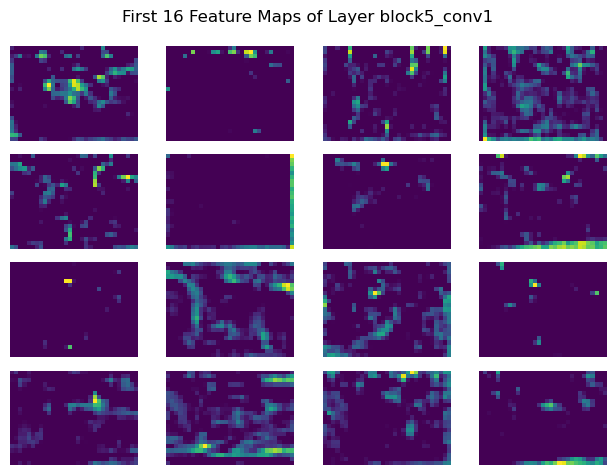

In [217]:
n_features = 16
n_layers = len(example_layers)
for i in range(n_layers):
    visualize_features(outputs[i], example_layers[i], n_features)

---

# Architecture Building: Part 1
## Using Tensorflow's Tutorial as a Guide for Implementing NST

In [9]:
# In the original paper, the authors chose the 2nd convolutional layer in the 4th block
# as the layer from which the content is extracted
content_layer = ['block4_conv2']

# Style layers were chosen as the first convolutional layer in each block
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [18]:
def extract_intermediate_features(model=vgg, layer_names=None):
    outputs = [model.get_layer(layer).output for layer in layer_names]
    extractor_model = Model([model.input], outputs)
    return extractor_model

def image_to_model_input(image_path, IMAGE_HEIGHT = 224, IMAGE_WIDTH = 224):
    raw_image = ImageOps.exif_transpose(Image.open(image_path))
    raw_image = np.array(raw_image)
    img = tf.convert_to_tensor(raw_image)
    
    img = tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH])
    img /= 255.0

    # img = tf.keras.applications.vgg19.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    
    return img

In [19]:
CONTENT_PATH = "images/content/flower.jpg"
STYLE_PATH = "images/styles/seascape_(gravelines)_.jpg"
content_image = image_to_model_input(CONTENT_PATH)
style_image = image_to_model_input(STYLE_PATH)

style_extractor_model = extract_intermediate_features(vgg, style_layers)
content_extractor_model = extract_intermediate_features(vgg, content_layer)

style_targets = style_extractor_model(style_image)
content_target = content_extractor_model(content_image)

In [20]:
def calculate_gram_matrix(input_tensor):
  copy = input_tensor
  copy = tf.squeeze(copy)

  copy = tf.reshape(copy, [copy.shape[2], copy.shape[0]*copy.shape[1]])

  result = tf.matmul(copy, copy, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

In [21]:
gram_style_targets = [calculate_gram_matrix(output) for output in style_targets]

In [22]:
def loss_function(content_output, style_outputs, alpha=0.0001, beta=0.1):

    gram_style_outputs = [calculate_gram_matrix(output) for output in style_outputs]

    # Calculate content loss
    content_loss = tf.reduce_mean(content_output - content_target) ** 2

    # Calculate style loss
    style_loss = []
    for n in range(len(style_outputs)):
        style_loss.append(tf.reduce_mean(gram_style_outputs[n] - gram_style_targets[n]) ** 2)
    
    style_loss = tf.add_n(style_loss)

    # Linear combination of content and style losses
    total_loss = (alpha * content_loss) + (beta * (1/len(style_outputs)) * style_loss)

    return total_loss

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [24]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)

In [25]:
@tf.function()
def train_step(image, a=0.0001, b=0.1):
    with tf.GradientTape() as tape:
        style_outputs = style_extractor_model(image)
        content_output = content_extractor_model(image)
        loss = loss_function(content_output=content_output, style_outputs=style_outputs, alpha=a, beta=b)
        print(loss)
    
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip(image))

In [23]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

---
---

In [30]:
initial_image = tf.Variable(content_image)

Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)


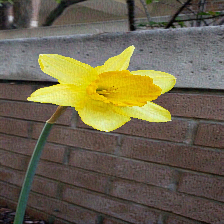

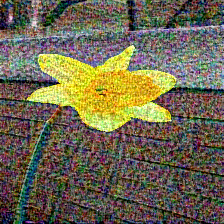

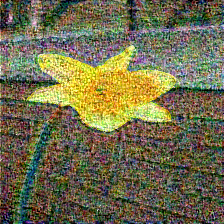

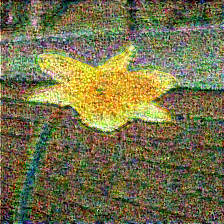

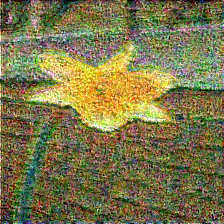

In [31]:
for i in range(201):
    train_step(initial_image)
    if i % 50 == 0:
        display(tensor_to_image(initial_image))

# Architecture Building: Part 2
## Implementing Tensorflow's Guide to NST Nearly Line by Line

In [88]:
content_layer = ['block4_conv2']

In [89]:
def load_img(image_path):
  max_dim = 512
  raw_image = ImageOps.exif_transpose(Image.open(image_path))
  raw_image = np.array(raw_image)
  img = tf.convert_to_tensor(raw_image)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [90]:
CONTENT_PATH = 'images/content/flower.jpg'
STYLE_PATH = 'images/styles/seascape_(gravelines)_.jpg'
content_image = load_img(CONTENT_PATH)
style_image = load_img(STYLE_PATH)

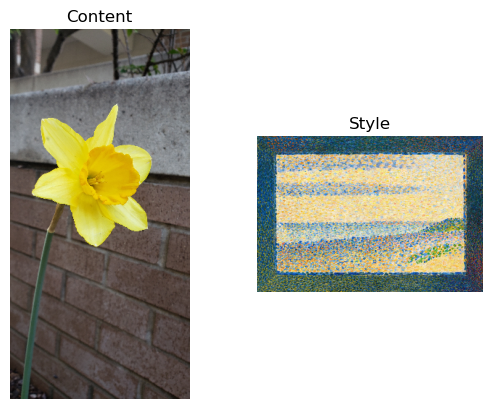

In [91]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(tf.squeeze(content_image))
ax[1].imshow(tf.squeeze(style_image))
ax[0].set_title('Content')
ax[1].set_title('Style')
ax[0].set_axis_off()
ax[1].set_axis_off()

In [92]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [93]:
extractor_model = StyleContentModel(style_layers, content_layer)

In [94]:
style_targets = extractor_model(style_image)['style']
content_targets = extractor_model(content_image)['content']

In [95]:
style_weight=1e-2
content_weight=1e-3

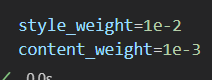

In [96]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [97]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_outputs)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(style_outputs)
    loss = style_loss + content_loss
    return loss

In [98]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor_model(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip(image))

In [99]:
# Random noise image
# content_dims = tf.squeeze(content_image).shape
# noise = np.random.normal(0, 1, content_dims)
# noise = clip(noise)
# noise = tf.expand_dims(noise, axis=0)
# input_image = tf.Variable(noise)

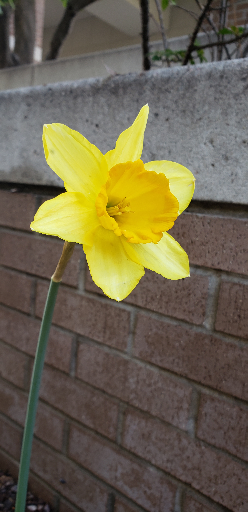

In [100]:
input_image = tf.Variable(content_image)
tensor_to_image(input_image)

In [101]:
for i in range(500):
    train_step(input_image)

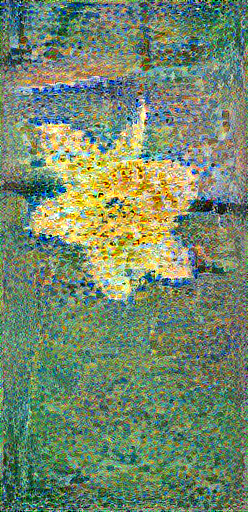

In [102]:
output_image = tensor_to_image(input_image)
output_image

In [62]:
def plot_content_style_output(content_image, style_image, output_image, output_title='Generated Image'):
    fig, ax = plt.subplots(1, 3, figsize=(13, 5))

    ax[0].imshow(tf.squeeze(content_image))
    ax[1].imshow(tf.squeeze(style_image))
    ax[2].imshow(output_image)
    ax[0].set_title('Content')
    ax[1].set_title('Style')
    ax[2].set_title(output_title)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    plt.tight_layout()

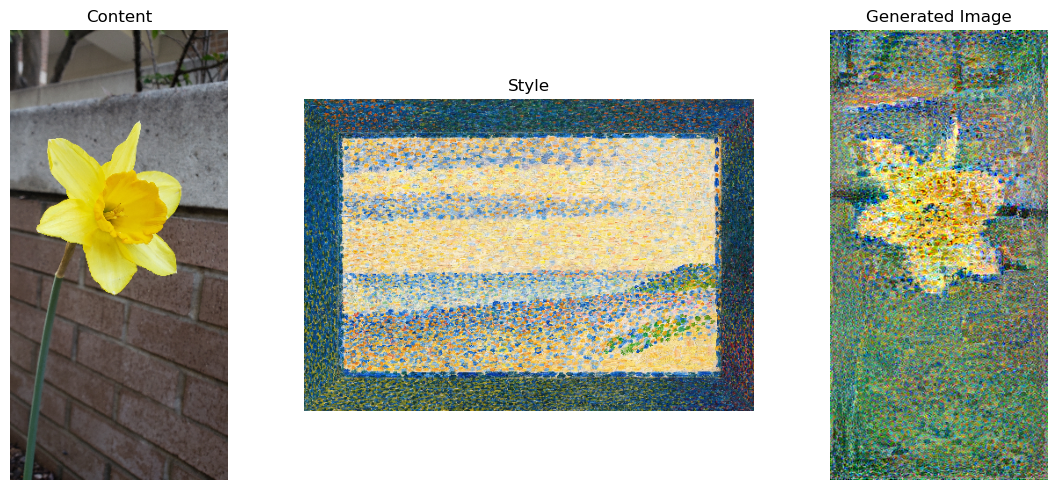

In [103]:
plot_content_style_output(content_image, style_image, output_image, output_title='Generated Image')

# Architecture Building: Part 3
## Functionalizing
---


# External Sources
https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

https://www.tensorflow.org/tutorials/generative/style_transfer

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/